In [1]:
# Code to test whether this ipynb was already ran before
a = 5 
a

5

This code is used to infer transit shape from input light curve.
It involves following steps:
1. Load ML model
2. Load input data - i.e. the light curves
3. Predict the shapes from the light curves

4. Load True Output (if any)

Load ML model

In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d

2024-04-10 11:21:32.325961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 11:21:33.263100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [2]:
# model_load = load_model("../ml_model/nov13_model1/nov13_model1_sample_interpolate_no_noise_unf_samplept_20to60.h5")
model_load = load_model("/scratch/abraham/Documents/mega_git/mega/ml_model/april9_2024_model/april9_2024_model_unfDist_LDC_size_horz_scale.h5")


2024-04-10 11:21:40.062200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20680 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Load Input data to infer on

In [3]:
# 1. Load Lightcurve Dataset
lc_dir =  '/scratch/abraham/Documents/mega_git/mega/data/test/npy/lc/lc_shape_1_multisize_multiLDC.npy'
# lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/random/npy/lc/lc_1_21Feb2024_circles_38_38_px.npy'
test_lc = np.load(lc_dir)

# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))



In [4]:
# Append with ones (if required only. 
# eg APPENING not required for BATMAN lightcurve since we already append BATMAN 
# while saving it as csv file and npy file)
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],150))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,25:125] = test_lc_scaled[i]
print("Extended the light curves")

del test_lc
del test_lc_scaled

Extended the light curves


In [5]:
# 5. Horizontal scaling
def scale_horizontally(input_lc_dataset):
    # lc_np_array_offset_mask used to select the flat part by certain percentage
    input_lc_dataset_mask = np.copy(input_lc_dataset)

    for iteration in np.arange(len(input_lc_dataset)):
        # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]>=0.98)] = 1.0
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]<0.98)] = 0.0

    print("Length of one LC = ", len(input_lc_dataset_mask[0]))

    count_zeros_array = np.zeros((len(input_lc_dataset_mask),))
    for iteration in np.arange(len(input_lc_dataset_mask)):
        # Calculate the number of occurrences of '0'
        count_zeros = np.count_nonzero(input_lc_dataset_mask[iteration] == 0)
        count_zeros_array[iteration] = count_zeros
    
    # Interpolate the light curve
    input_lc_dataset_interpol = np.zeros((len(input_lc_dataset), 120))
    len_selected_portion = np.zeros(len(input_lc_dataset))
    print("input_lc_dataset_interpol.shape =", input_lc_dataset_interpol.shape)

    center_index = int(len(input_lc_dataset[0])/2)
    print("center_index =", center_index)

    for iteration in np.arange(len(input_lc_dataset_interpol)):

        left_index = int(center_index - int(count_zeros_array[iteration]/2) - int(count_zeros_array[iteration]/6))
        right_index = int(center_index + int(count_zeros_array[iteration]/2) + int(count_zeros_array[iteration]/6))
        selected_portion = input_lc_dataset[iteration][left_index:right_index]
        # print("left_index =", left_index)
        # print("right_index =", right_index)

        # Calculate the length of the selected region
        len_selected_portion[iteration] = len(selected_portion)

        # Interpolate the selected portion
        # Original data
        original_x = np.linspace(-1, 1, num=len(selected_portion))
        original_y = selected_portion

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=120)

        # Perform the interpolation
        y_interpolated = f(x_interpolation)
        input_lc_dataset_interpol[iteration] = y_interpolated

    return input_lc_dataset_interpol

test_lc_horiz_scaled = scale_horizontally(test_lc_scaled_append)
del test_lc_scaled_append

processed_test_lc = test_lc_horiz_scaled
del test_lc_horiz_scaled


Length of one LC =  150
input_lc_dataset_interpol.shape = (250, 120)
center_index = 75


Predict Shape

In [6]:
# Test on the ML model - Test Dataset - Original Simulated light curve 
# (i.e. without sampling and interpolation)
# Test dataset - Prediciton
test_predict_shape = model_load.predict(processed_test_lc)
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

2024-04-10 11:23:30.421724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


8/8 [==============================] - 3s 21ms/step
Normalized the predicted shape


Plot (a single set) - Adjust index k to get the kth I/O
1. input light curve 
2. predicted output

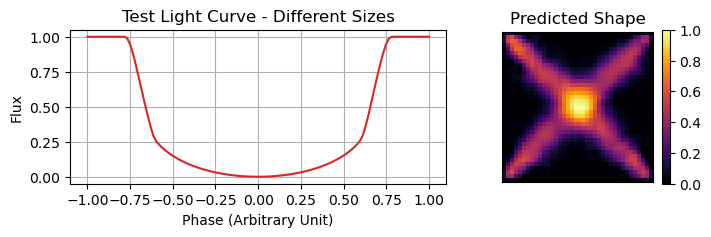

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8,2),gridspec_kw={'width_ratios': [2,1]})  # 1 row, 2 columns
ph = np.linspace(-1,1,len(processed_test_lc[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title('Test Light Curve - Different Sizes')
axes[0].plot(ph, processed_test_lc[k], color='tab:red')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')


axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()


Load True Output if any

In [8]:
# shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/vald/npy/shape/shape_1.npy'
# shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/random/npy/shape/14Feb2024_circle_38_38_px.npy'

shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/test/npy/shape/shape_1.npy'
test_shape = np.load(shape_dir)

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)

Miscellance Operations
1. Plot input lightcurve
2. Show predicted output
3. Show true output

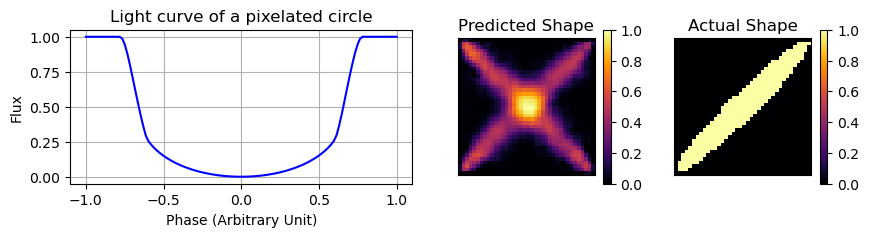

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2),gridspec_kw={'width_ratios': [2,1,1]})  # 1 row, 3 columns
ph = np.linspace(-1,1,len(processed_test_lc[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title('Light curve of a pixelated circle')
axes[0].plot(ph, processed_test_lc[k], color='blue')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')

axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

axes[2].set_title('Actual Shape')
axes[2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[2].imshow(test_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()

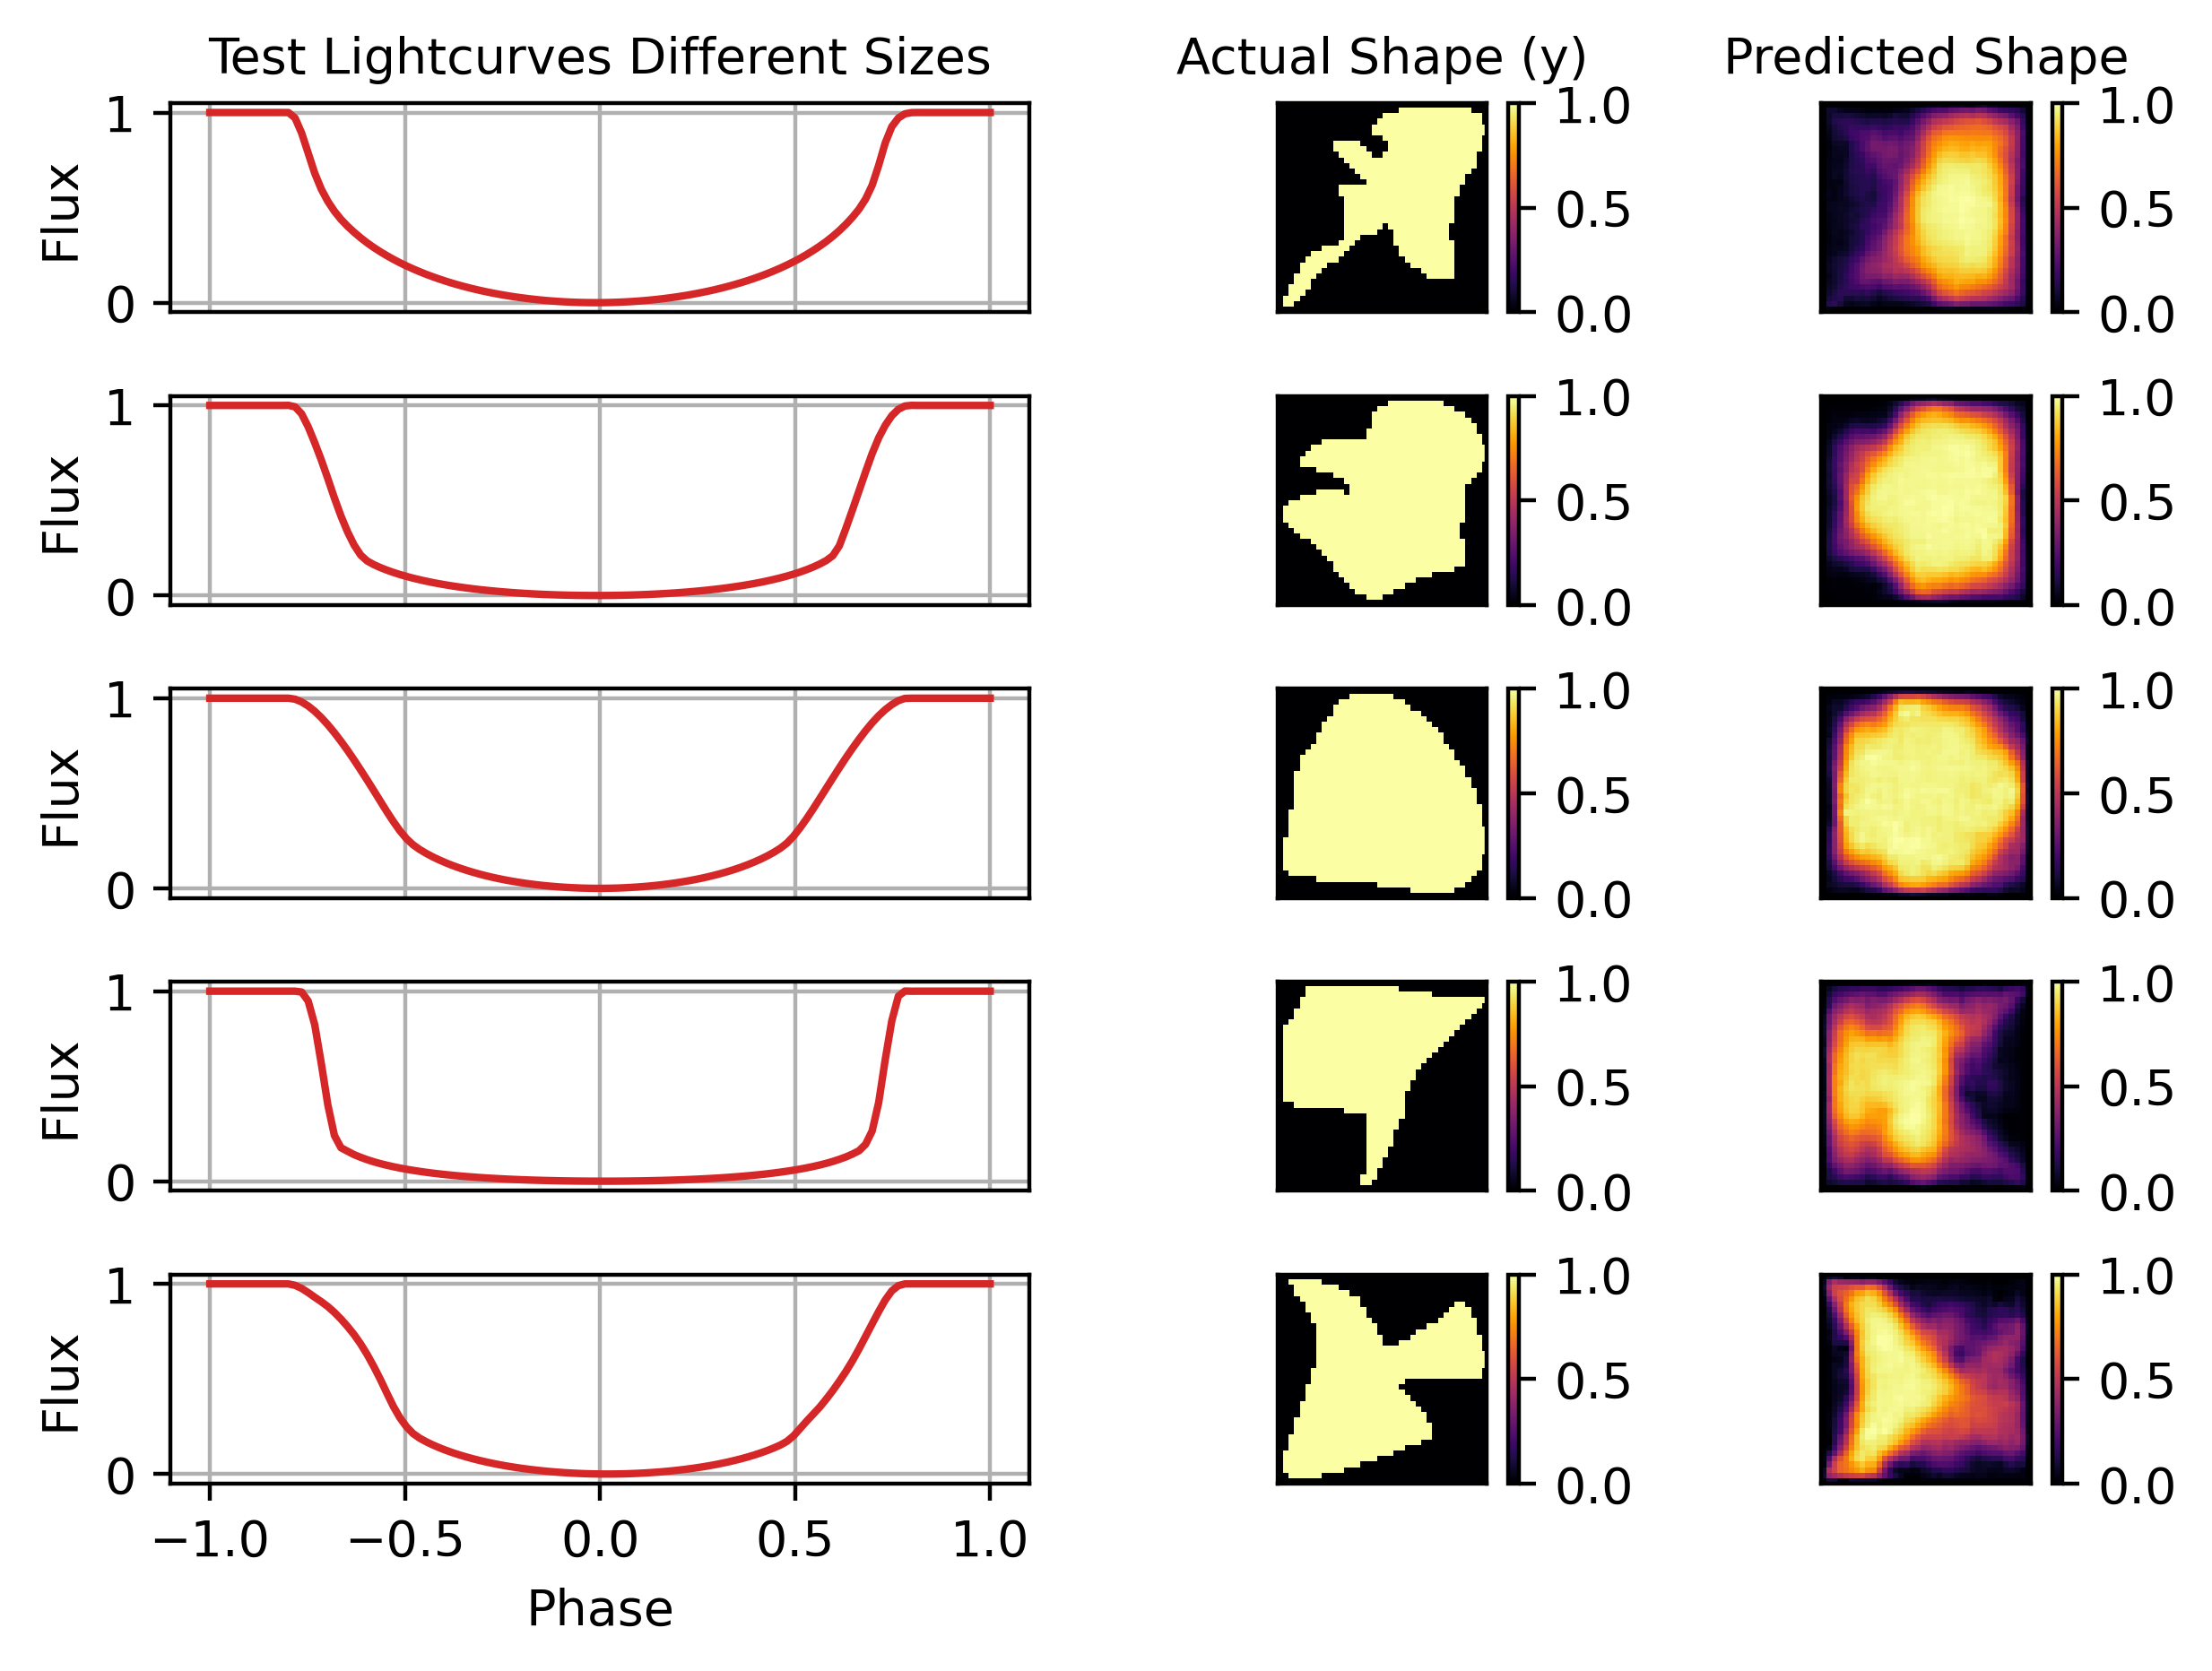

In [17]:
# Plot random set of 5 light curves and predictions
num = 5
fig,ax=plt.subplots(num,3, figsize=(7,5), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][0].set_title('Test Lightcurves Different Sizes',size=10)
ax[0][1].set_title('Actual Shape (y)',size=10)
ax[0][2].set_title(r'Predicted Shape',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1.0,1.0,len(processed_test_lc[0]))
# advance = 60
for i in range(num):
    k =  random.randint(0, len(processed_test_lc)-1) # 249 - i #
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    # ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, processed_test_lc[k],color = 'tab:red',linewidth=1.5)
    ax[i][0].grid('on')
    img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
    plt.colorbar(img)

# plt.suptitle('Test Dataset Prediction (LDCs a = 0.23, b = 0.05)')
plt.show()

In [13]:
# All the required codes for folding and calculating MSE

def fold_original_image_array(org_image_array):
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
    folded_org_image_array[folded_org_image_array>0] = 1
    return(folded_org_image_array)

def fold_predicted_image_array(org_image_array):
    threshold = 0.3
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
        folded_org_image_array[i] = (folded_org_image_array[i] - np.amin(folded_org_image_array[i]))/(np.amax(folded_org_image_array[i]) - np.amin(folded_org_image_array[i]))
    folded_org_image_array[folded_org_image_array>=threshold] = 1
    folded_org_image_array[folded_org_image_array<threshold] = 0
    return(folded_org_image_array)

def calc_MSE(ary1,ary2):
    MSE = 0
    if ary1.shape == ary2.shape:
        for i in np.arange(len(ary1)):
            MSE = MSE + np.mean((ary1[i] - ary2[i])**2)
        MSE = MSE/len(ary1)
        # print("MSE = ",MSE)
        return(MSE)
    else:
        print("Given array shape not same")

# Fold the original shapes
folded_test_shape_array = fold_original_image_array(test_shape)

# Fold the predicted shapes for different SNR
folded_predicted_shape_array = fold_predicted_image_array(test_predict_shape)

# Calculate Folder MSE
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array)
print("MSE = ",mse)

MSE =  0.13421606648199447
